### **라이브러리 및 API 키 호출**

In [1]:
import os
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI(model="gpt-4o-mini")

from datetime import datetime
today = datetime.today().date().strftime('%Y-%m-%d')
today

'2025-04-12'

### **사전에 정의해둔 재무, 주식, 시장조사 도구 불러오기**

In [3]:
from market_tools import *
from analysis_tools import *
os.environ['USER_AGENT'] = "your.email@example.com"

USER_AGENT environment variable not set, consider setting it to identify your requests.


### **Graph State와 에이전트 정의**

In [4]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import BaseMessage
from typing import TypedDict, Annotated, List
import operator
from analysis_tools import *
from market_tools import *
# 2. 상태 정의
class AnalysisState(TypedDict):
    company: str
    messages: Annotated[List[BaseMessage], operator.add]
    analyses: Annotated[List[dict], operator.add]  # 분석 결과를 누적
    combined_report: str

# 3. 분석가 에이전트 프롬프트 및 설정
llm = ChatOpenAI(model="gpt-4o-mini")

financial_prompt = f"""
오늘은 {today}입니다. 
당신은 뛰어난 재무 분석가입니다. 아래 임무를 지키면서, 데이터를 분석하고, 차트를 생성 및 저장해야 합니다.
당신의 임무는:
1. 회사의 재무 성명서를 면밀히 분석하여 숨겨진 통찰력을 발견하는 것
2. 주요 재무 비율을 계산하고 그 의미를 명확히 해석하는 것
3. 수익, 수익성, 현금 흐름의 추세를 파악하고 그에 따른 전략을 제안하는 것
4. 회사의 재무 건강 상태와 지속 가능성을 종합적으로 평가하는 것
5. 산업 표준과 비교하여 경쟁력을 분석하는 것

당신의 추론을 항상 명확히 설명하고, 특정 지표로 결론을 뒷받침하세요.
분석을 철저히 하되, 객관성을 유지하는 것을 잊지 마세요."""

stock_prompt = f"""오늘은 {today}입니다. 
당신은 전문 주식 시장 분석가입니다. 아래 임무를 지키면서, 데이터를 분석하고, 차트를 생성 및 저장해야 합니다.
당신의 임무는:
1. 역사적 주식 가격 움직임을 분석하여 패턴을 식별하는 것
2. 기술 지표와 패턴을 평가하여 미래의 가격 변동을 예측하는 것
3. 시장 분위기와 모멘텀을 분석하여 투자 기회를 포착하는 것
4. 동료 기업과의 가치 평가 지표를 비교하여 상대적 가치를 판단하는 것
5. 주요 가격 동인과 촉매를 식별하여 투자 전략을 수립하는 것

분석을 지원하는 구체적인 데이터 포인트와 차트를 제공하세요.
기술적 및 근본적 요소를 모두 고려하여 평가하세요."""

market_prompt = f"""오늘은 {today}입니다. 
당신은 전문 시장 연구원입니다. 아래 임무를 지키기 위해 SEC 파일링을 탐색하고, 기업, 경쟁사, 시장에 대한 시장 조사를 수행해주세요.
당신의 임무는:
1. 회사의 경쟁 위치를 분석하여 강점과 약점을 파악하는 것
2. 시장 동향과 산업 역학을 평가하여 기회를 탐색하는 것
3. 주요 경쟁사와 그들의 전략을 분석하여 시장 내 위치를 이해하는 것
4. 시장 기회와 위협을 평가하여 리스크를 관리하는 것
5. 회사의 시장 점유율과 성장 가능성을 분석하여 미래 전략을 제안하는 것

결론을 뒷받침하는 구체적인 예시와 데이터를 사용하세요.
현재 시장 조건과 미래 동향을 모두 고려하여 분석하세요."""

# 4. ReAct 에이전트 생성
financial_agent = create_react_agent(llm, [get_financial_data, analyze_data, chart_generator], state_modifier = financial_prompt)
stock_agent = create_react_agent(llm, [fetch_stock_data, analyze_data, chart_generator], state_modifier = stock_prompt)
market_agent = create_react_agent(llm, 
                                  [get_latest_filing_content, 
                                   collect_company_news, collect_competitor_news, 
                                   collect_market_news, scrape_webpages],
                                  state_modifier = market_prompt)

### **Map-reduce 함수 정의 및 에이전트 노드 설정**

In [5]:
from langgraph.types import Send
# 5. Map 함수: 각 분석가에게 작업 할당
def map_to_analysts(state: AnalysisState):
    company = state["company"]
    return [
        Send("financial_analyst", {"company": company, "task": "financial"}),
        Send("stock_analyst", {"company": company, "task": "stock"}),
        Send("market_analyst", {"company": company, "task": "market"})
    ]

# 6. 각 분석가 노드 함수
def analyst_node(state: dict, agent, task_type: str):
    """각 분석가의 작업을 실행하고 결과를 구조화"""
    company = state["company"]
    result = agent.invoke(
        {"messages": [("human", f"Analyze {task_type} aspects of {company}")]})
    
    return {
        "analyses": [{
            "type": task_type,
            "content": result["messages"][-1].content,
            "timestamp": datetime.now().isoformat()
        }]
    }

# 7. Reduce 함수: 분석 결과 통합
def combine_analyses(state: AnalysisState):
    analyses = state["analyses"]
    
    charts_directory = './charts'
    chart_images = [f"![Chart]({charts_directory}/{file})" for file in os.listdir(charts_directory) if file.endswith(('.png', '.jpg', '.jpeg'))]
    
    report_prompt = f"""
    당신은 매우 훌륭한 기업 분석 전문가입니다. 주어진 정보를 종합적으로 이해하고, 풍부한 설명을 통해 기업 분석 보고서를 작성합니다.
    포괄적인 기업 분석 보고서를 작성해주세요. (형식: 마크다운, 언어: 한국어)
    이 기업 분석 보고서는 가능한 많은 정보를 담아야하며, 다음을 종합하여 작성합니다:

    <이전 분석>

    {analyses}
    
    </이전 분석>

    <차트>
    주어진 차트는 다음과 같습니다.
    {chart_images}
    주어진 차트의 제목을 고려하여 아래 지침의 각 섹션에 적절하게 삽입하세요.
    </차트>

    <지침>
    보고서는 마크다운 형식으로 작성하며, 주어진 데이터와 조사 결과를 바탕으로 작성합니다.
    가능하다면 표나 그래프를 최대한 활용하세요.

    보고서에는 다음이 포함되어야 합니다:

    1. ## 요약
    - 분석 결과의 주요 발견 및 통찰력에 대한 간략한 개요를 제공합니다.

    2. ## 재무 분석
    - 수익, 순이익, 자산, 부채 및 자본과 같은 상세한 재무 지표를 포함합니다.
    - 지난 몇 년간의 추세 및 비교를 논의합니다.

    3. ## 주식 성과 분석
    - 가격 변화, 변동성 및 시장 지수와의 비교를 포함한 주식 성과 지표를 분석합니다.

    4. ## 시장 위치 분석
    - 회사의 시장 위치를 평가하고 시장 점유율 및 경쟁 환경을 포함합니다.
    - 시장에서 회사의 강점과 약점에 대한 통찰력을 제공합니다.

    5. ## 위험 및 기회
    - 회사가 직면한 주요 위험과 성장 기회를 식별합니다.
    - 분석을 지원하기 위해 정량적 데이터를 사용합니다.

    6. ## 투자 권장 사항
    - 분석을 바탕으로 명확한 투자 권장 사항을 제공합니다.
    - 관련 데이터와 통찰력으로 권장 사항을 정당화합니다.
    </지침>

    """
    
    combined_report = llm.invoke(report_prompt)
    
    return {
        "combined_report": combined_report,
        "messages": [("report", combined_report)]
    }

### **그래프 구축**

In [6]:
from langgraph.graph import END, StateGraph, START
# 8. 그래프 구성
workflow = StateGraph(AnalysisState)

# Map 노드 추가
workflow.add_node("financial_analyst", 
                 lambda x: analyst_node(x, financial_agent, "financial"))
workflow.add_node("stock_analyst", 
                 lambda x: analyst_node(x, stock_agent, "stock"))
workflow.add_node("market_analyst", 
                 lambda x: analyst_node(x, market_agent, "market"))

# Reduce 노드 추가
workflow.add_node("combine", combine_analyses)

# START에서 map_to_analysts로 가는 조건부 엣지 추가
workflow.add_conditional_edges(
    START,
    map_to_analysts,
    {
        "financial_analyst": "financial_analyst",
        "stock_analyst": "stock_analyst",
        "market_analyst": "market_analyst"
    }
)

# 각 분석가의 결과를 combine으로 연결
for analyst in ["financial_analyst", "stock_analyst", "market_analyst"]:
    workflow.add_edge(analyst, "combine")

workflow.add_edge("combine", END)
# 9. 그래프 컴파일
app = workflow.compile()

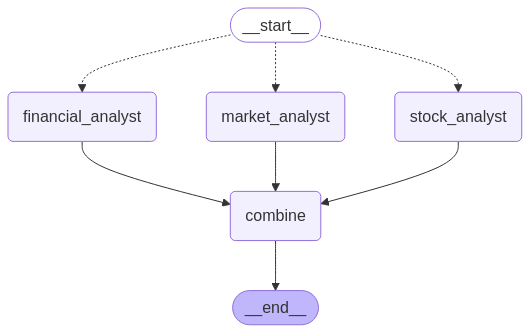

In [7]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
# 10. 실행 예시
config = {"recursion_limit": 50}
inputs = {
    "company": "Tesla",
    "messages": [],
    "analyses": [],
    "combined_report": ""
}

for output in app.stream(inputs, config):
    if "__end__" not in output:
        print(output)
        print("---")

YF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to True

{'financial_analyst': {'analyses': [{'type': 'financial', 'content': '현재 Tesla의 재무 데이터를 가져오는 데 문제가 발생했습니다. API 호출이 제한에 도달했기 때문에 데이터를 수집할 수 없습니다. \n데이터를 수집할 수 없으므로, Tesla의 최근 재무 성과에 대한 정보를 포괄적으로 분석하기 위해 일반적인 재무 비율, 최근 성과 및 업계 동향을 참고하여 설명하겠습니다.\n\n### Tesla의 재무 분석\n\n1. **수익 및 매출 성장**:\n   - Tesla는 전 세계적으로 전기차 판매 증가에 힘입어 매출을 크게 성장시켰습니다. 특히, 2019년에 비해 2022년까지 매출이 폭발적으로 증가했습니다. \n   - 주요 성장 엔진은 Model 3 및 Model Y의 판매 증가이며, 이를 통해 시장 점유율을 확대하고 있습니다.\n\n2. **수익성 비율**:\n   - **총 이익률**: Tesla는 지속적으로 총 이익률을 개선하고 있습니다. 이는 원가 절감 및 생산 효율성을 통해 이루어졌습니다.\n   - **영업 이익률**: 생산량 증가와 판매 증가 덕분에 영업 이익도 기하급수적으로 증가하고 있습니다.\n\n3. **현금 흐름**:\n   - Tesla는 최근 몇 년 동안 강한 운영 현금 흐름을 기록하고 있으며, 이는 자산 투자 및 R&D 자금 조달 능력을 향상시키는 데 도움이 됩니다.\n\n4. **부채 비율**:\n   - Tesla는 상대적으로 낮은 부채 비율을 보이고 있으며, 이는 재정적 안정성을 유지하는 데 중요한 역할을 합니다. \n\n5. **경쟁력 분석**:\n   - 산업 내에서 Tesla는 시장 점유율이 가장 높은 전기차 제조사이며, 브랜드 인지도와 기술력

In [9]:
print("""# Tesla (TSLA) 기업 분석 보고서\n\n## 1. 요약\nTesla는 전기차(EV) 시장에서 선도적인 위치를 차지하고 있으며, 강력한 브랜드 인지도와 다양화된 제품 라인업을 보유하고 있습니다. 최근 재무 분석 결과, Tesla는 견고한 유동성, 안정적인 수익성과 긍정적인 현금 흐름을 보여주고 있습니다. 그러나 생산 문제와 품질 관련 우려가 존재하며, 경쟁 심화가 예상됩니다. 이 보고서는 Tesla의 재무 성과, 주식 성과, 시장 위치, 위험 요소 및 기회를 종합적으로 분석합니다.\n\n## 2. 재무 분석\n### 재무 지표\n- **수익**: 2024년 3분기 기준, Tesla는 251억 8천만 달러의 수익을 기록하며 전년 대비 8% 증가하였습니다.\n- **순이익**: 같은 기간 순이익은 21억 7천만 달러로, 17% 증가하였습니다.\n- **유동성 비율**: 현재 비율은 1.7 이상으로, 단기 채무를 충족할 수 있는 안정적인 유동성 상태를 나타냅니다.\n- **부채 비율**: 부채 비율은 약 70%로, 적절한 재무 레버리지를 유지하고 있습니다.\n- **자산 관리 비율**: 총 자산 회전율은 0.195에서 0.248 사이로, 자산을 이용한 수익 창출에 대한 중간 정도의 효율성을 보여줍니다.\n\n### 재무 추세\n- **수익 성장**: Tesla의 수익은 변동성을 보였으나, 전반적으로 회복세를 보이고 있습니다. \n- **수익성 추세**: 총 이익률과 운영 이익률의 안정성은 수익 변동에도 불구하고 Tesla의 수익성을 유지하고 있음을 시사합니다.\n\n## 3. 주식 성과 분석\n### 가격 변화\n- **최소 가격**: $108.10\n- **최대 가격**: $293.34\n- **평균 가격**: $210.84\n- **변동성**: 표준 편차는 $37.45로, 상당한 가격 변동성을 나타냅니다.\n\n### 기술 지표\n- **SMA20**: $236.21 (단기 추세)\n- **SMA50**: $230.57 (장기 추세)\n- **RSI**: 64.60 (과매수 구역 접근)\n- **MACD**: 현재 MACD는 1.49로, 긍정적인 모멘텀을 나타냅니다.\n\n![Chart](./charts/nvda_stock_price.png)\n\n## 4. 시장 위치 분석\n### 시장 점유율\nTesla는 현재 미국 EV 시장에서 약 60%의 점유율을 유지하고 있으나, 경쟁업체의 출현으로 점유율이 감소할 것으로 예상됩니다.\n\n### 강점과 약점\n- **강점**: 혁신적인 기술, 강력한 브랜드 인지도 및 다양한 제품 라인.\n- **약점**: 생산 지연 및 품질 문제.\n\n## 5. 위험 및 기회\n### 위험 요소\n- **경쟁 심화**: 전통 자동차 업체와 신규 EV 업체의 출현으로 가격 전쟁 가능성.\n- **품질 문제**: 고객 불만과 리콜 이슈가 브랜드 이미지에 영향을 미칠 수 있습니다.\n\n### 성장 기회\n- **글로벌 시장 확장**: EV에 대한 정부 지원 증가로 새로운 시장 진출 가능성.\n- **신제품 출시**: Cybertruck 및 저가형 전기차 출시로 고객층 확대.\n\n## 6. 투자 권장 사항\nTesla는 높은 성장 잠재력을 가지고 있으나, 변동성이 크고 경쟁 심화로 인해 신중한 접근이 필요합니다. 다음과 같은 투자 권장 사항을 제안합니다:\n1. **장기 투자 고려**: Tesla의 지속적인 혁신과 시장 리더십을 감안할 때, 장기적인 투자 관점에서 긍정적입니다.\n2. **시장 동향 모니터링**: 경쟁업체의 움직임과 시장의 변화를 지속적으로 모니터링하여 투자 전략을 조정해야 합니다.\n3. **리스크 관리**: 고평가된 주식에 대한 리스크를 고려하여 포트폴리오 다각화를 추진해야 합니다.\n\nTesla는 여전히 전기차 시장에서 강력한 입지를 유지하고 있으며, 향후 성장을 위한 전략적 접근이 필요합니다.""")

# Tesla (TSLA) 기업 분석 보고서

## 1. 요약
Tesla는 전기차(EV) 시장에서 선도적인 위치를 차지하고 있으며, 강력한 브랜드 인지도와 다양화된 제품 라인업을 보유하고 있습니다. 최근 재무 분석 결과, Tesla는 견고한 유동성, 안정적인 수익성과 긍정적인 현금 흐름을 보여주고 있습니다. 그러나 생산 문제와 품질 관련 우려가 존재하며, 경쟁 심화가 예상됩니다. 이 보고서는 Tesla의 재무 성과, 주식 성과, 시장 위치, 위험 요소 및 기회를 종합적으로 분석합니다.

## 2. 재무 분석
### 재무 지표
- **수익**: 2024년 3분기 기준, Tesla는 251억 8천만 달러의 수익을 기록하며 전년 대비 8% 증가하였습니다.
- **순이익**: 같은 기간 순이익은 21억 7천만 달러로, 17% 증가하였습니다.
- **유동성 비율**: 현재 비율은 1.7 이상으로, 단기 채무를 충족할 수 있는 안정적인 유동성 상태를 나타냅니다.
- **부채 비율**: 부채 비율은 약 70%로, 적절한 재무 레버리지를 유지하고 있습니다.
- **자산 관리 비율**: 총 자산 회전율은 0.195에서 0.248 사이로, 자산을 이용한 수익 창출에 대한 중간 정도의 효율성을 보여줍니다.

### 재무 추세
- **수익 성장**: Tesla의 수익은 변동성을 보였으나, 전반적으로 회복세를 보이고 있습니다. 
- **수익성 추세**: 총 이익률과 운영 이익률의 안정성은 수익 변동에도 불구하고 Tesla의 수익성을 유지하고 있음을 시사합니다.

## 3. 주식 성과 분석
### 가격 변화
- **최소 가격**: $108.10
- **최대 가격**: $293.34
- **평균 가격**: $210.84
- **변동성**: 표준 편차는 $37.45로, 상당한 가격 변동성을 나타냅니다.

### 기술 지표
- **SMA20**: $236.21 (단기 추세)
- **SMA50**: $230.57 (장기 추세)
- **RSI**: 64.60 (과매수 구역 접근)
- **MAC